In [1]:
import hifive
import matplotlib.pyplot as plt
import numpy as np
import pybedtools as bed

In [6]:
hic=hifive.HiC('/Users/cmdb/qbb2020-answers/week11/genome/project.hic', 'r')
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)
data +=1
enrichment = data[:,:,0]/data[:,:,1]
log_trans = np.log(enrichment)

Finding fend full array for chr13:1000000-120250001... Done


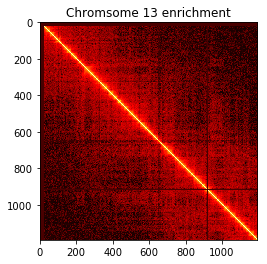

In [7]:
plt.imshow(log_trans, cmap='hot', interpolation='nearest')
plt.title('Chromsome 13 enrichment')
plt.show()

In [8]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Finding expected full array for chr13:3000000-120300000... Done
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arr

In [9]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

In [139]:
np.shape(X)

(1168, 2)

In [140]:
np.shape(Y)

(1168,)

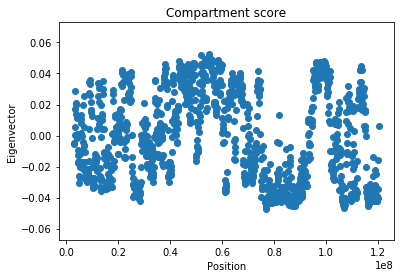

In [150]:
plt.scatter(X[:, 0], Y)
plt.title('Compartment score')
plt.xlabel('Position')
plt.ylabel('Eigenvector')
plt.show()

In [55]:
gene_data = open('./data/WT_fpkm.bed', 'r')
genes = {}
for line in gene_data:
    if 'chr13' not in line:
        continue
    else:
        lines = line.split('\t')
        name = lines[3]
        start = int(lines[1])
        end = int(lines[2])
        FPKM = float(lines[4])
        genes.setdefault(name, [start, end, FPKM])
print(genes)

{'Gm17750': [84164902, 84204379, 0.0], 'Tpbpb': [61002656, 61006208, 0.0], 'Nsa2': [97899382, 97907881, 164.765036531], 'Rnf44': [54780760, 54795321, 96.2888655842], 'Arhgef28': [98668550, 98976120, 6.86887351155], 'Tpbpa': [61039853, 61043297, 0.0], 'Pelo': [115878563, 115880366, 23.1716048966], 'Olfr1359': [21794843, 21795834, 0.0], '4930526H09Rik': [111672619, 111694054, 0.0], 'Gm26688': [40823177, 40830531, 0.0210726094943], 'A330076C08Rik': [44288958, 44311856, 0.0], 'Mir692-3': [74544513, 74544621, 0.0], 'Ccnh': [85328990, 85353336, 57.1144849036], 'Grk6': [55546433, 55562288, 64.7089729369], 'Gcm2': [41196796, 41205357, 0.0114768501866], 'Col4a3bp': [97312690, 97410122, 27.7591017027], 'Gm5141': [62873560, 62887168, 5.57486046319], 'Nrsn1': [25343908, 25361865, 6.08632777082], 'Hnrnpa0': [58227240, 58229917, 166.85214753], 'Mier3': [112476386, 112508802, 13.5391210997], '4930555G21Rik': [53743954, 53745450, 0.0], 'Rnf180': [105937574, 106083094, 0.544044824368], 'Rnf182': [43711

In [22]:
hic_data = open('./hic_comp.bed', 'r')
hic_value = []
for line in hic_data:
    lines = line.rstrip().split('\t')
    start = int(lines[1])
    end = int(lines[2])
    value = float(lines[3])
    int_list = [start, end, value]
    hic_value.append(int_list)

In [62]:
gene_values = {}
for key, value in genes.items():
    for int_list in hic_value:
        if int_list[0] <= value[1] and int_list[1] >= value[0]:
            if key not in gene_values.keys():
                gene_values.setdefault(key, [int_list[2]])
            else:
                gene_values[key].append(int_list[2])
        elif int_list[1] >= value[0] and value[1] >= int_list[0]:
            if key not in gene_values.keys():
                gene_values.setdefault(key, [int_list[2]])
            else:
                gene_values[key].append(int_list[2])
        else:
            continue

In [65]:
positive = []
negative = []
for key, value in gene_values.items():
    neg_count = 0
    pos_count = 0
    for i in range(0, len(value)):
        if value[i] < 0:
            neg_count+=1
        elif value[i] > 0:
            pos_count+=1
    if pos_count > neg_count:
        positive.append(key)
    else:
        negative.append(key)

In [84]:
import math

In [89]:
positive_exp = {}
for element in positive:
    if element in genes.keys():
        values = genes[element]
        exp = values[2]
        exp += 1
        log_trans = math.log(exp, 2)
        positive_exp.setdefault(element, log_trans)
        

In [91]:
negative_exp = {}
for element in negative:
    if element in genes.keys():
        values = genes[element]
        exp = values[2]
        exp +=1
        log_trans = math.log(exp, 2)
        negative_exp.setdefault(element, log_trans)

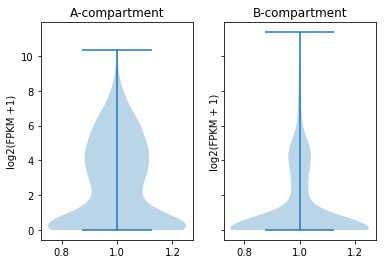

In [100]:
fig, ax = plt.subplots(nrows =1, ncols=2, sharey = True)

ax[0].violinplot(positive_exp.values())
ax[0].set_title('A-compartment')
ax[0].set_ylabel('log2(FPKM +1)')
ax[1].violinplot(negative_exp.values())
ax[1].set_title('B-compartment')
ax[1].set_ylabel('log2(FPKM + 1)')
plt.show()

In [157]:
import pyBigWig
A_H3K = []
for key, value in positive_exp.items():
    if key in genes.keys():
        gene = key
        FPKM = genes[key][2]
        start = genes[key][0]
        end = genes[key][1]
        bw = pyBigWig.open('data/WT_H3K27me3.bw')
        H3K = bw.stats('chr13', start , end , type='sum')
        data = [gene, FPKM, H3K[0]]
        A_H3K.append(data)
        

In [158]:
B_H3K = []
for key, value in negative_exp.items():
    if key in genes.keys():
        gene = key
        FPKM = genes[key][2]
        start = genes[key][0]
        end = genes[key][1]
        bw = pyBigWig.open('data/WT_H3K27me3.bw')
        H3K = bw.stats('chr13', start , end , type='sum')
        data = [gene, FPKM, H3K[0]]
        B_H3K.append(data)

In [113]:
import pandas as pd

In [159]:
df_A = pd.DataFrame(A_H3K, columns = ['gene', 'log2FPKM', 'H3K'])
df_A['H3K'] = df_A['H3K'].fillna(0)
df_A

,gene,log2FPKM,H3K
0,Nsa2,164.765037,5.202020
1,Rnf44,96.288866,2.114405
2,Olfr1359,0.000000,0.000000
3,Gm26688,0.021073,46.791875
4,A330076C08Rik,0.000000,7.286027
5,Ccno,5.650017,12.517922
6,Mir1904,0.000000,650.000000
7,Col4a3bp,27.759102,4.609394
8,Gm5141,5.574860,2.028538
9,Hnrnpa0,166.852148,2996.000000


In [160]:
df_B = pd.DataFrame(B_H3K, columns = ['gene', 'log2FPKM', 'H3K'])
df_B['H3K'] = df_B['H3K'].fillna(0)
df_B

,gene,log2FPKM,H3K
0,1700001L19Rik,0.140443,5.829311
1,Ctla2a,6.671582,749.000000
2,Ctla2b,0.086422,308.000000
3,Gm17750,0.000000,8.544587
4,Tpbpb,0.000000,1.000000
5,2210408I21Rik,1.766230,5.775649
6,Prl4a1,0.000000,5.550236
7,Tpbpa,0.000000,2.000000
8,Vmn1r217,0.000000,564.000000
9,Vmn1r216,0.000000,404.000000


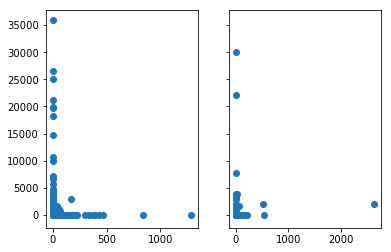

In [163]:
fig, ax = plt.subplots(ncols= 2, sharey = True)
ax[0].scatter(df_A['log2FPKM'], df_A['H3K'])
ax[1].scatter(df_B['log2FPKM'], df_B['H3K'])
plt.show()